In [163]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import matthews_corrcoef
from sklearn.preprocessing import StandardScaler
from sklearn import svm
import missingno as msno
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline

colors = sns.crayon_palette(['Tickle Me Pink', 'Atomic Tangerine', 'Fuzzy Wuzzy'])

# load dataset
train_df = pd.read_csv("./Sberbank/train.csv", parse_dates=['timestamp'], index_col=False)
test_df = pd.read_csv("./Sberbank/test.csv", parse_dates=['timestamp'], index_col=False)
macro_df = pd.read_csv("./Sberbank/macro.csv", parse_dates=['timestamp'], index_col=False)
train_df = pd.merge(train_df, macro_df, how='left', on='timestamp')
test_df = pd.merge(test_df, macro_df, how='left', on='timestamp')


train_df['month'] = train_df['timestamp'].dt.month
train_df['day'] = train_df['timestamp'].dt.day
train_df['year'] = train_df['timestamp'].dt.year

# Outliers/Transformations
Y_train = pd.DataFrame(train_df['price_doc']).values
X_train = pd.DataFrame(train_df.loc[:, train_df.columns != 'price_doc'].values)
# X_test = test.values

In [135]:
date_range = [train_df['timestamp'].min(),train_df['timestamp'].max()]
print date_range

[Timestamp('2011-08-20 00:00:00'), Timestamp('2015-06-30 00:00:00')]


In [136]:
time_price = train_df.loc[:, ['timestamp','price_doc']]
time_price = time_price.set_index('timestamp')

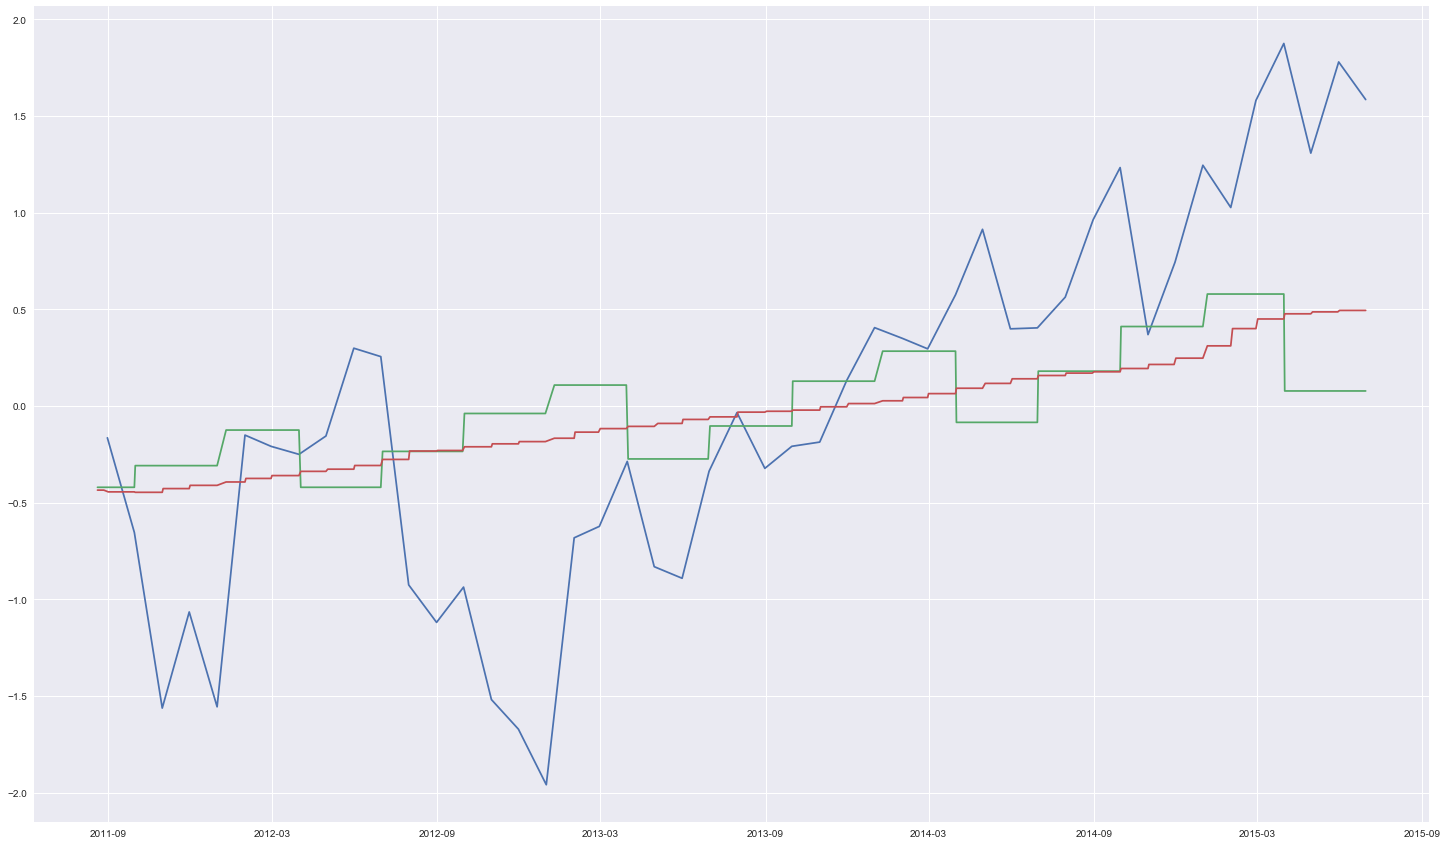

In [181]:
price_per_day = train_df.loc[:, ['timestamp','price_doc']].groupby('timestamp').mean()
price_per_day = (price_per_day - price_per_day.mean()) / (price_per_day.max() - price_per_day.min())
gdp_day = train_df.loc[:, ['timestamp','gdp_quart']].groupby('timestamp').mean()
gdp_day = (gdp_day - gdp_day.mean()) / (gdp_day.max() - gdp_day.min())
cpi = train_df.loc[:, ['timestamp','cpi']].groupby('timestamp').mean()
cpi = (cpi - cpi.mean()) / (cpi.max() - cpi.min())




plt.figure(figsize=(25, 15))
plt.plot(price_per_day.resample('M').sum())
plt.plot(gdp_day)
plt.plot(np.log1p(cpi))
plt.show()


In [138]:
by_month = train_df.loc[:,['month','year','price_doc']]
by_month = by_month.reset_index()

price_per_month = train_df.groupby(['month','year']).mean()['price_doc']


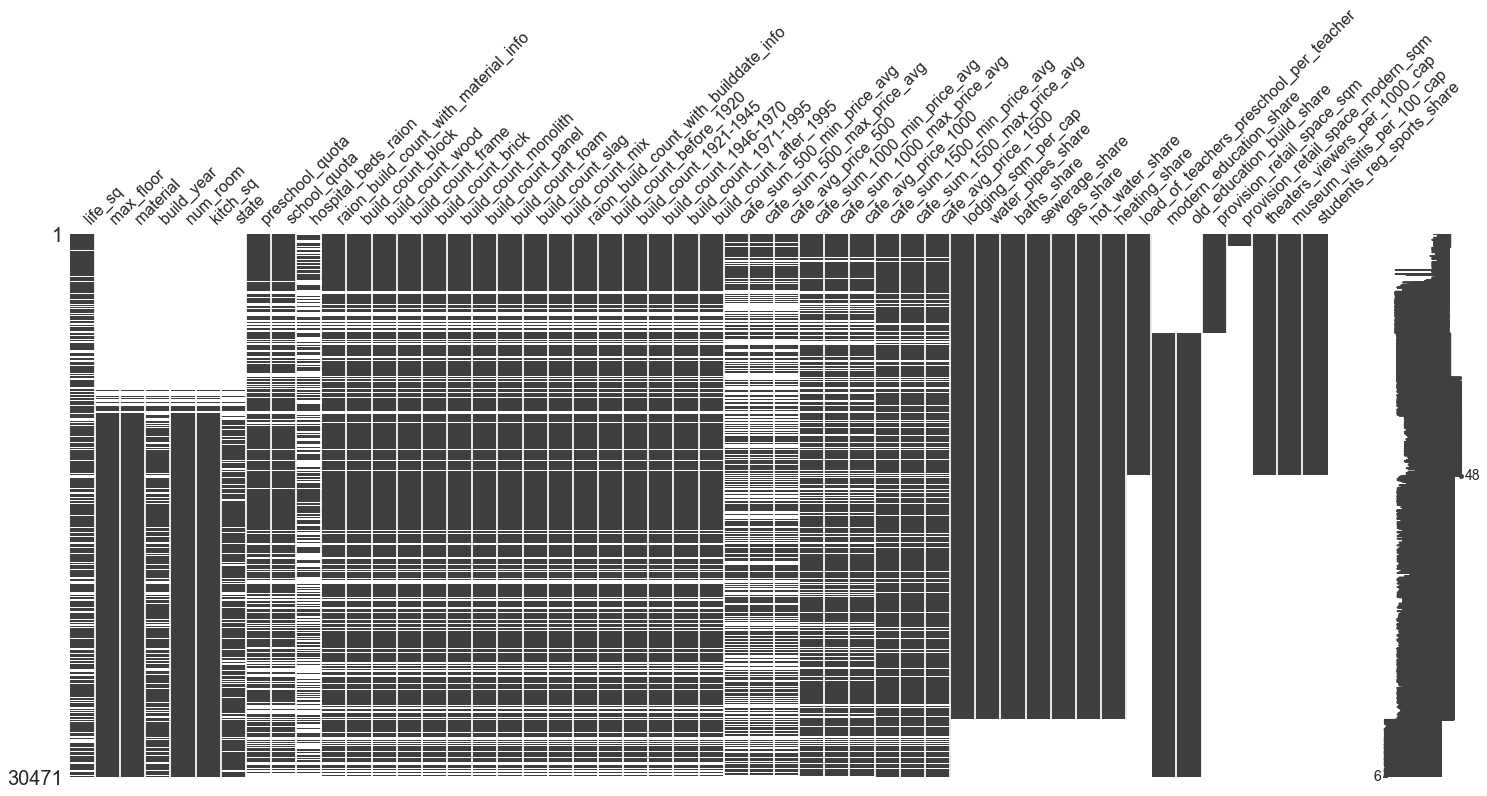

In [139]:
filtered_data = msno.nullity_filter(train_df, filter='bottom', n=50, p=0.999) # or filter='top'
msno.matrix(filtered_data)

### Looking at features in macro.csv

In [140]:
important_macro_features = ['gdp_quart', 'cpi', 'ppi', 'usdrub', 'eurrub', 
                            'gdp_annual', 'rts', 'micex', 'micex_cbi_tr', 'deposits_rate', 
                            'mortgage_rate', 'income_per_cap', 'salary', 'labor_force', 
                            'unemployment', 'employment']

macro_feature_df = train_df.loc[:, important_macro_features]

In [141]:
results = sm.OLS(train_df['price_doc'], macro_feature_df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              price_doc   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     34.66
Date:                Tue, 23 May 2017   Prob (F-statistic):          2.71e-100
Time:                        09:33:19   Log-Likelihood:            -5.1162e+05
No. Observations:               30471   AIC:                         1.023e+06
Df Residuals:                   30455   BIC:                         1.023e+06
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
gdp_quart        -70.3725     29.567     -2.

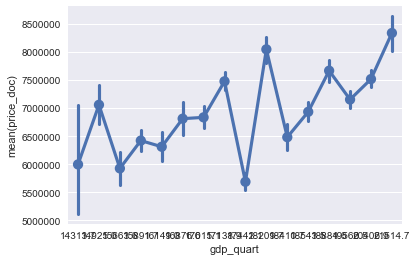

In [142]:
sns.pointplot(train_df['gdp_quart'],train_df['price_doc'])

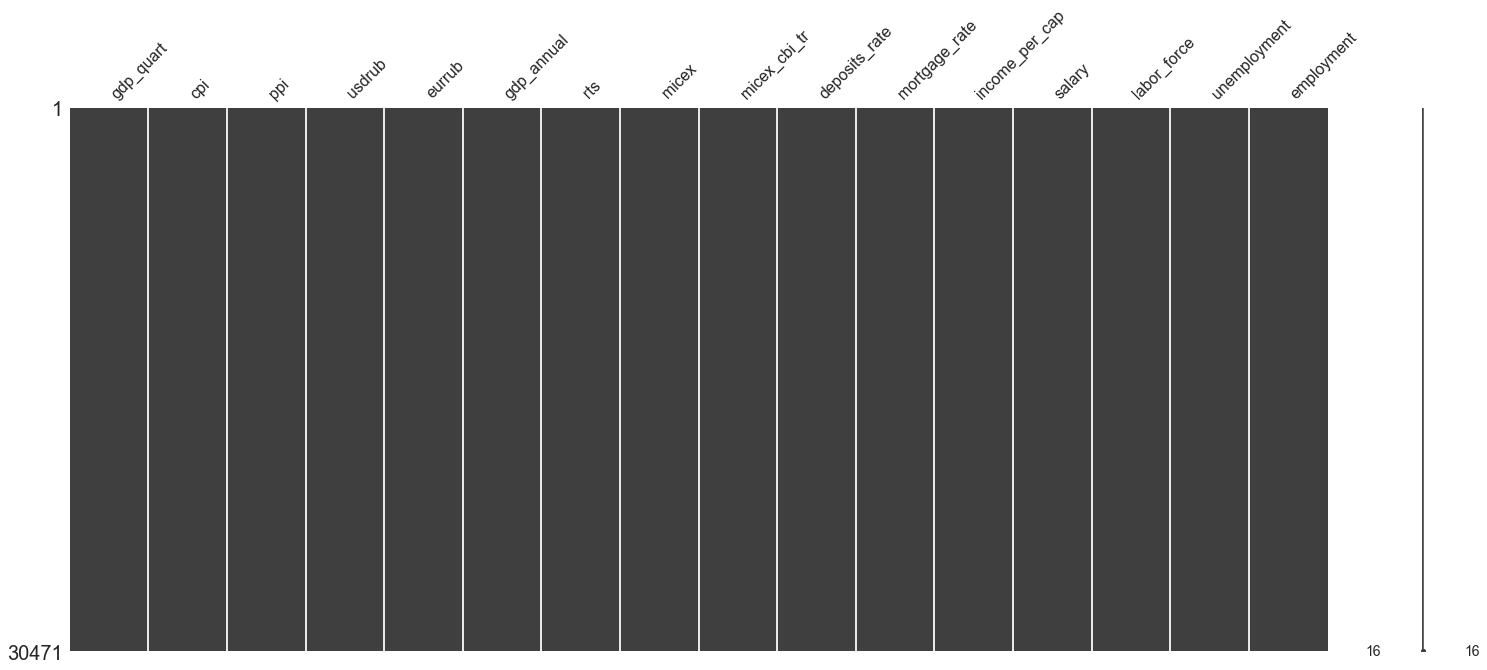

In [143]:
msno.matrix(macro_feature_df)

no missing features!

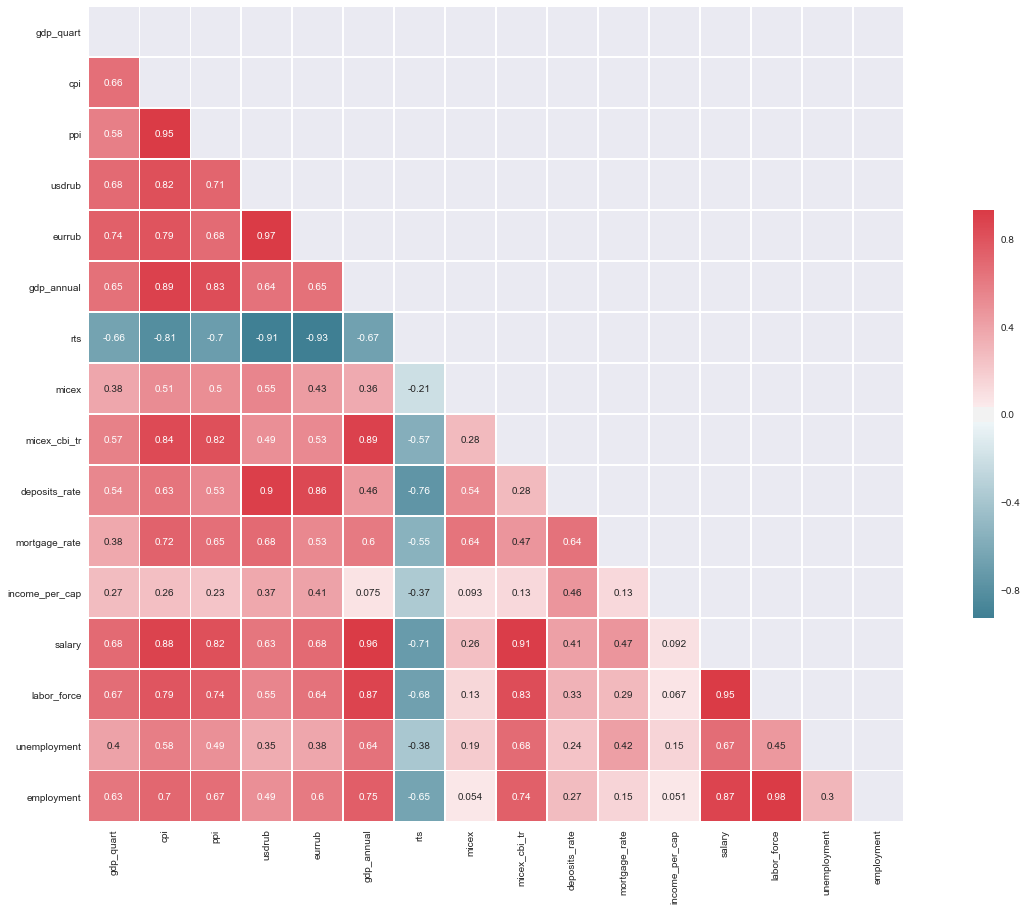

In [179]:
corr = macro_feature_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(25, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

In [145]:
corr2 = train_df[['gdp_quart','gdp_annual']].corr()

corr2

,gdp_quart,gdp_annual
gdp_quart,1.000000,0.649213
gdp_annual,0.649213,1.000000


In [146]:
corr3 = train_df[['gdp_quart','gdp_annual','price_doc']].corr()

corr3

,gdp_quart,gdp_annual,price_doc
gdp_quart,1.000000,0.649213,0.080978
gdp_annual,0.649213,1.000000,0.113976
price_doc,0.080978,0.113976,1.000000


not finding any significant correlation so we will look at time series

[0        46308.5
1        46308.5
2        46308.5
3        46308.5
4        46308.5
5        46308.5
6        46308.5
7        46308.5
8        46308.5
9        46308.5
10       46308.5
11       46308.5
12       46308.5
13       46308.5
14       46308.5
15       46308.5
16       46308.5
17       46308.5
18       46308.5
19       46308.5
20       46308.5
21       46308.5
22       46308.5
23       46308.5
24       46308.5
25       46308.5
26       46308.5
27       46308.5
28       46308.5
29       46308.5
          ...   
30441    77945.1
30442    77945.1
30443    77945.1
30444    77945.1
30445    77945.1
30446    77945.1
30447    77945.1
30448    77945.1
30449    77945.1
30450    77945.1
30451    77945.1
30452    77945.1
30453    77945.1
30454    77945.1
30455    77945.1
30456    77945.1
30457    77945.1
30458    77945.1
30459    77945.1
30460    77945.1
30461    77945.1
30462    77945.1
30463    77945.1
30464    77945.1
30465    77945.1
30466    77945.1
30467    77945.1
30468    7794

TypeError: unhashable type: 'numpy.ndarray'

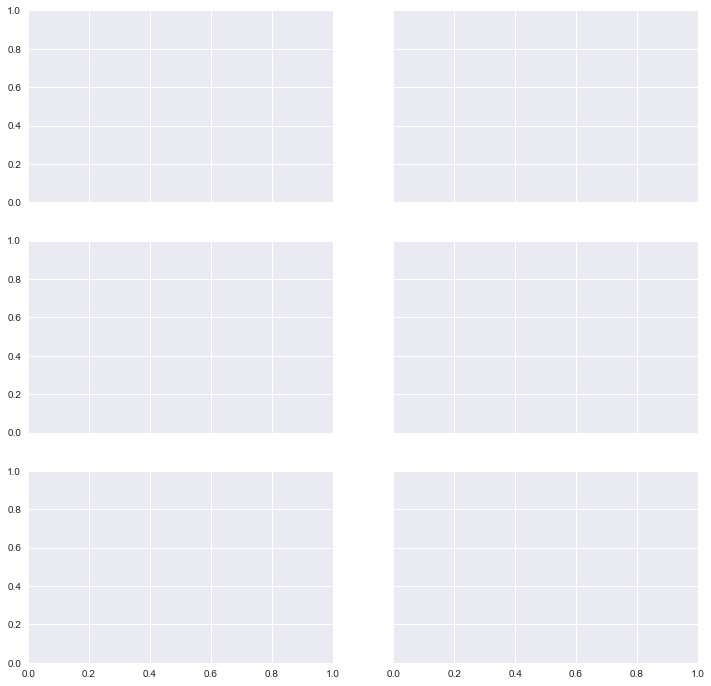

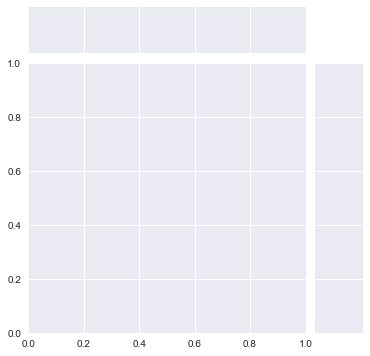

In [175]:
fns = [lambda x: x, np.square, np.sqrt,
       np.log, np.log1p, np.log10]

print [fn(train_df['gdp_annual']) for fn in fns]

def trans_plot(df, x, y, fns):    
    ulimit = np.percentile(train_df[y].values, 98.5)
    llimit = np.percentile(train_df[y].values, 1.5)
    train_df[y].loc[train_df[y]>ulimit] = ulimit
    train_df[y].loc[train_df[y]<llimit] = llimit
    
    ulimit = np.percentile(train_df[x].values, 98.5)
    llimit = np.percentile(train_df[x].values, 1.5)
    train_df[x].loc[train_df[x]>ulimit] = ulimit
    train_df[x].loc[train_df[x]<llimit] = llimit
    
    f, axes = plt.subplots(3, 2, figsize=(12, 12), sharex=True, sharey=True)
    for fn in fns:
        sns.jointplot(fn(df[x]).values, df[y].values, data=df, kind="reg", dropna=True)
        plt.ylabel('{0}'.format(y), fontsize=10)
        plt.xlabel('{1}'.format(y), fontsize=10)              
    return plt.plot()

# x_='gdp_quart'
# y_='price_doc'
trans_plot(train_df, 'gdp_quart', 'price_doc', fns)
# sns.jointplot(x = train_df[x_],y = train_df[y_], size=10, kind="kde")

# train_df[x_]